In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
# from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import louvain_communities,modularity
# from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.centrality import girvan_newman
import warnings
warnings.filterwarnings('ignore')

# Task 1 – Story

- "Series Haven", is a TV shows streaming platform created by a startup based in Kiel. It has some TV shows being streamed in the platform but the company wants to add more popular TV shows in the platform. Being a startup, founders have limited money to buy TV shows streaming rights. So, they want to find out the most popular TV shows along with the other alike shows. To figure out how to do this, they hired me as a data scientist.

- The company already have datasets of facebook pages of TV shows liking each other pages. This dataset is an undirected graph type. Now, my job/goal of the project is to find out the most liked tv show pages and similar TV shows which are linked with each other by mutual likes between them. Most liked TV show pages indicates most popular TV shows and mutual likes inferences that they are likely to have similar audience preferences.

- We have two sets of dataset where one dataset has unique id and name, to each tv show page, and the other dataset has two columns which represent two different tv show pages liking each other.
    - First, I would load datasets into dataframes and then do data analysis on them. This includes "showing how many unique pages are there", "which are the most liked pages", and what is the distribution of likes between the pages.
    - Second, I would calculate the important graph properties and analyze what kind of network the dataset(graph) is. I would also create random similar graphs and evaluate their properties with the original graph.
    - Then, I would find out centrally important tv show pages (most popular) and analyze them.
    - Finally, I would evaluate most important pages and their alike pages by detecting their communities as the project goal.


# Task 2 – The Data

In [2]:
edges_df = pd.read_csv('data/fb-pages-tvshow-edges.csv')
edges_df.head()

,node1,node2
0,0,1838
1,0,1744
2,0,14
3,0,2543
4,1,1009


In [3]:
nodes_df = pd.read_csv('data/fb-pages-tvshow-nodes.csv')
nodes_df.head()

,id,name,new_id
0,183215455178728,Orange is the New Black,1852
1,282808121926963,狮城有约 Hello Singapore,592
2,179653538737148,DC Cupcakes,1370
3,162816367111296,Gladiatorerna,1263
4,134115896703387,Globo Rural,3042


### Dataset Description
- The dataset is about facebook pages of tv shows liking each other's pages.
- Here a node is a facebook page of a tv show and an edge is a mutual liking of two tv show pages.
- We are two datasets, where one is the metadata giving a node's aka facebook page's name information and other one is main dataset where the edges information between two pages (nodes) is given.
- The main dataset (fb-pages-tvshow-edges.csv) has two columns named as node1 and node2 where both of them are facebook pages of two different tv shows liking each other's pages.
    - The pages are indicated as unique integer ids in this dataset. 
    - So, node1 and node2 are of datatype integer.
- The metadata (fb-pages-tvshow-nodes.csv) has 3 columns:
    - id: unique facebook identifier (number)
    - name: name of tv show's facebook page (string)
    - new_id: unique identifier for representating a node (number) 
- This data is also undirected because it is based on mutual likes between the pages/nodes.

***How is this dataset relevant to the story??***

- Facebook is one of the most if the most used social media in the world. The likes on the pages of TV shows is an actual indicator of how popular are they in the physical world.
- And, TV show pages that share a siginificant number of mutual likes i.e. edges are likely to have similar audience preferences.

# Task 3 – IDA

In [4]:
df = edges_df.copy()
df.head()


,node1,node2
0,0,1838
1,0,1744
2,0,14
3,0,2543
4,1,1009


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17262 entries, 0 to 17261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   node1   17262 non-null  int64
 1   node2   17262 non-null  int64
dtypes: int64(2)
memory usage: 269.8 KB


In [6]:
df.shape

(17262, 2)

In [7]:
df.isna().sum()

node1    0
node2    0
dtype: int64

In [8]:
df = df.drop_duplicates(keep='first')
df.shape

(17262, 2)

- No null values present in the dataset.
- The no of mutual likes between pages present in the dataset is 17262.

In [9]:
node1_shows = set(df['node1'].to_list())
node2_shows = set(df['node2'].to_list())

shows = node1_shows.union(node2_shows)
print('No of tv shows listed: {}'.format(len(shows)))

No of tv shows listed: 3892


In [10]:
x = set(nodes_df['new_id'].to_list())
x.symmetric_difference(shows)

{657, 879, 1385, 1558, 1674, 1811, 2336, 3699, 3781, 3805, 3820}

- There are 3892 tv show pages listed in the dataset.
- 11 of them don't have a metadata.

### Top 10 most liked tv show pages visualization

In [11]:
# create a dictionary with keys as node ids of every show list and value as count of them in the data
nodes_dict = {key: 0 for key in shows}    
# iterate rows in main dataframe
# track count of appearance of each show in nodes_dict
for i,row in df.iterrows():
    if row.iloc[0] in shows:
        nodes_dict[row[0]] += 1
    if row.iloc[1] in shows:
        nodes_dict[row[1]] += 1


In [12]:
# create a sorted dictionary of tv shows based on their values/count
sorted_nodes_dict = dict(sorted(nodes_dict.items(), key=lambda item: item[1],reverse=True))
# initialize lists to comprehend top 10 most like pages name and their counts
top10_page_names = []
top10_page_counts = []
counter = 0
for k,v in sorted_nodes_dict.items():
    if counter < 10:
        name = nodes_df[nodes_df['new_id'] == k]['name'].values[0]
        top10_page_names.append(name)
        top10_page_counts.append(v)
        counter+=1
    else:
        break

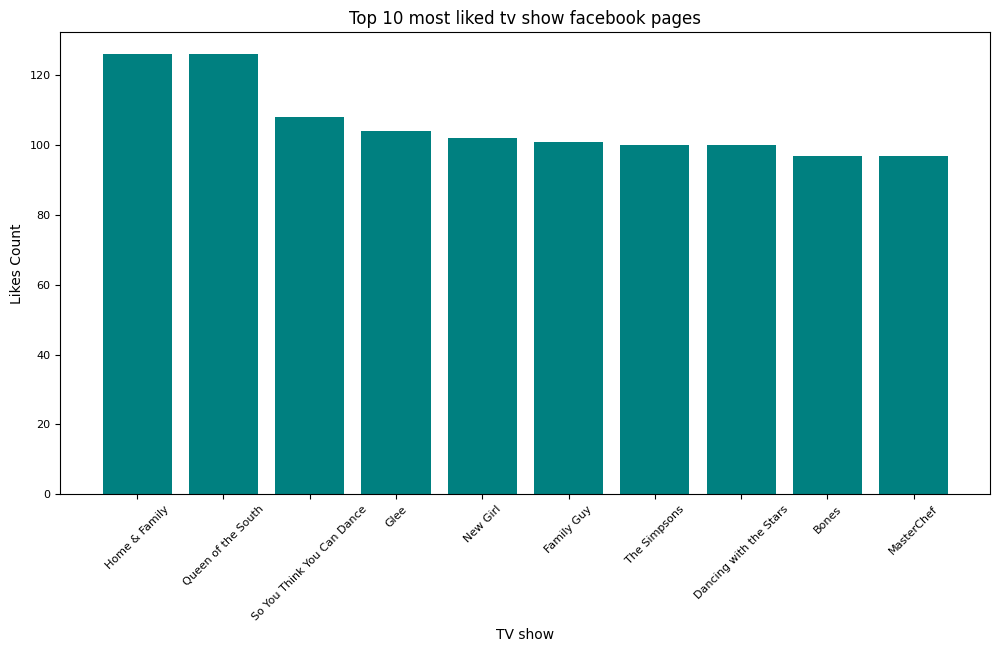

In [13]:
# plot top 10 liked shows

fig = plt.figure(figsize = (12, 6))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.xticks(rotation=45)
plt.title('Top 10 most liked tv show facebook pages')
plt.xlabel('TV show')
plt.ylabel('Likes Count')
plt.bar(top10_page_names, top10_page_counts, width=0.8, color='teal')

plt.show()

- "Home & Family" and "Queen of the South" are the most liked/popular shows with likes count of 126. These top 10 pages have a very high degree and are potentially crucial for the network.

#### Creating a graph using the nodes and edges from the dataframe

In [14]:
G = nx.from_pandas_edgelist(df= df,
                            source="node1",
                            target="node2",
                            create_using=nx.Graph())


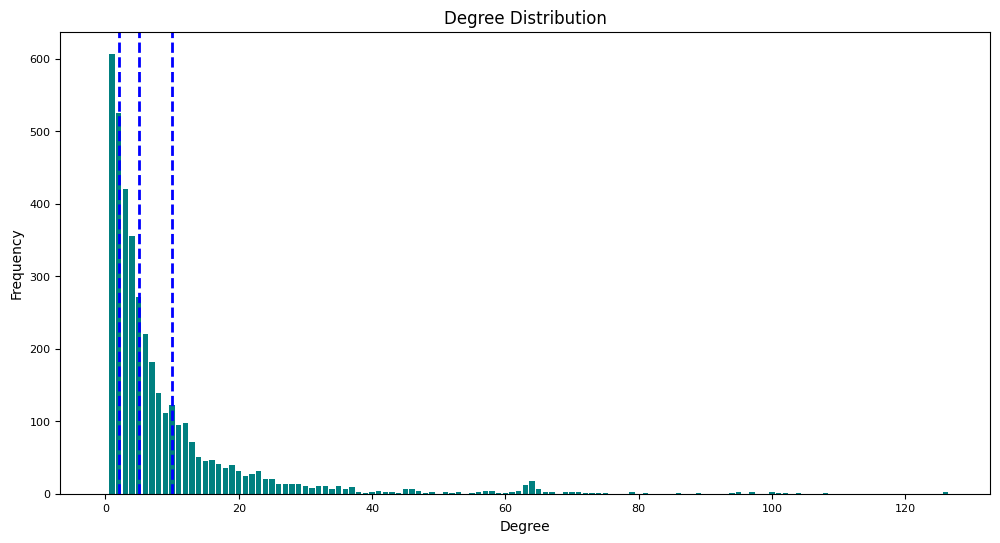

Degrees are distributed in the following quartiles values (Q1,Q2,Q3) = [ 2.  5. 10.]


In [15]:
degrees = dict(G.degree())
degree_values = list(degrees.values())
degree_hist = nx.degree_histogram(G)
#quartiles in degrees
quartiles = np.percentile(degree_values, [25, 50, 75])
fig = plt.figure(figsize = (12, 6))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
#barplot
plt.bar(range(len(degree_hist)), degree_hist, width=0.8, color='teal')
# Mark quartiles on the plot
for q in quartiles:
    plt.axvline(q, color='b', linestyle='--', linewidth=2, label=f'Q{int((quartiles.tolist().index(q) + 1))}')

plt.show()
print('Degrees are distributed in the following quartiles values (Q1,Q2,Q3) = {}'.format(quartiles))

- From the above degree distribution, it is clear that the distribution is right skewed having most values on the left side of the graph.
- 75% of the nodes/pages have mutual likes lesser than 10.
- There are very few pages which have high degree/mutual likes, these must be quite popular in the TV series world.

# Task 4 – Graph Properties

#### Firstly, converting nodes of type integer to their respective names for better analysis later

In [16]:
nodes_id = nodes_df['new_id'].unique()

for id in shows:
    arr = nodes_df[nodes_df['new_id']==id]['name'].values
    if len(arr)>0:
        name = arr[0]
        df = df.replace({id:name})


In [17]:
df.head()

,node1,node2
0,Dancing With The Stars. Taniec z Gwiazdami,Twoja twarz brzmi znajomo
1,Dancing With The Stars. Taniec z Gwiazdami,Hell's Kitchen Polska
2,Dancing With The Stars. Taniec z Gwiazdami,Pierwsza miłość
3,Dancing With The Stars. Taniec z Gwiazdami,TOP CHEF Polska
4,Chris Jansing,Morning Joe


#### Initializing a dicitionary to store all properties of the graph

In [18]:
# list of properties
PROPERTIES = ['num_nodes','num_edges','density','is_connected','average_shortest_path_length','transitivity','assortativity']
properties_dict = dict()

### Creating a graph from pandas dataframe

In [19]:
G = nx.from_pandas_edgelist(df= df,
                            source="node1",
                            target="node2",
                            create_using=nx.Graph())

In [20]:
G.edges()

EdgeView([('Dancing With The Stars. Taniec z Gwiazdami', 'Twoja twarz brzmi znajomo'), ('Dancing With The Stars. Taniec z Gwiazdami', "Hell's Kitchen Polska"), ('Dancing With The Stars. Taniec z Gwiazdami', 'Pierwsza miłość'), ('Dancing With The Stars. Taniec z Gwiazdami', 'TOP CHEF Polska'), ('Twoja twarz brzmi znajomo', 'Galileo Polska'), ('Twoja twarz brzmi znajomo', 'Przyjaciółki'), ("Hell's Kitchen Polska", "Hell's Kitchen"), ("Hell's Kitchen Polska", 'Demakijaż - talk show'), ("Hell's Kitchen Polska", 'TOP CHEF Polska'), ("Hell's Kitchen Polska", 'Przyjaciółki'), ('Pierwsza miłość', 'Ojciec Mateusz serial TVP'), ('Pierwsza miłość', 'Świat według Kiepskich'), ('Pierwsza miłość', 'Policjantki i policjanci - serial'), ('TOP CHEF Polska', 'Demakijaż - talk show'), ('TOP CHEF Polska', 'Galileo Polska'), ('TOP CHEF Polska', 'Top Chef'), ('TOP CHEF Polska', 'Przyjaciółki'), ('Chris Jansing', 'Morning Joe'), ('Chris Jansing', 'Now With Alex Wagner'), ('Chris Jansing', "The Last Word With

In [21]:
len(G.edges)

17254

In [22]:
G.nodes()

NodeView(('Dancing With The Stars. Taniec z Gwiazdami', 'Twoja twarz brzmi znajomo', "Hell's Kitchen Polska", 'Pierwsza miłość', 'TOP CHEF Polska', 'Chris Jansing', 'Morning Joe', 'Now With Alex Wagner', "The Last Word With Lawrence O'Donnell", 'Andrea Mitchell Reports', 'The Rachel Maddow Show', 'The Daily Show', 'Up on MSNBC', 'The Ed Show', 'Jour Polaire', 'NBC Nightly News with Lester Holt', 'Alex Witt', 'Hardball with Chris Matthews', 'MSNBC Live with José Díaz-Balart', 'Meet the Press', 'PoliticsNation with Al Sharpton', "Steve Austin's Broken Skull Challenge", 'CMT Music Awards', 'Love Island', 'Redneck Island', 'Couples Therapy', 'American Grit', 'Wayward Pines', 'MasterChef', 'Houdini & Doyle', 'The X-Files', 'The Grinder', 'Superhuman', 'FOX Teen Choice Awards', 'The Exorcist FOX', 'Pitch', 'STAR', 'American Idol', 'The Orville', 'Son of Zorn', 'Rosewood', 'The Mick', 'The Four', 'Living Biblically', 'Scream Queens', 'Bordertown', 'Shots Fired', "New Year's Eve on FOX", 'New 

In [23]:
len(G.nodes())

3863

In [24]:
# setting no of nodes and edges in the properties dict
properties_dict['num_nodes'] = len(G.nodes())
properties_dict['num_edges'] = len(G.edges())

##### Nodes and Edges

- The network has 3863 nodes/facebook pages of tv shows
- The network has 17254 edges i.e. 17254 mutual likes between 3863 pages are there.

##### Density

In [25]:
density = nx.density(G)
# setting density in the properties dict
properties_dict['density'] = density
print('Density of the network: ',density)

Density of the network:  0.00231303823484108


- The density of the network is quite low, closer to zero which infers there are a lot of nodes which are not connected to each other.
- This means, many pages have not liked each other's pages and it's sparse network.

##### Connectiveness

In [26]:
is_connected = nx.is_connected(G)
# setting is_connected in the properties dict
properties_dict['is_connected'] = is_connected
print('Is the network fully connected:',is_connected)

Is the network fully connected: True


- The network is fully connected which means every node through some edges can be reached from every other node.
- All pages are somehow connected such that even if two pages don't have a like between them directly, they certainly have either a direct mutual page or an indirect like links between them.

##### Average shortest path length

In [27]:
average_shortest_path = nx.average_shortest_path_length(G)
# setting average_shortest_path in the properties dict
properties_dict['average_shortest_path_length'] = average_shortest_path
print("Average Shortest Path Length:", average_shortest_path)

Average Shortest Path Length: 6.171881637969969


- The average shortest path length is a measureof how well-connected or efficient a network is.
- In our network it's value is 6.1718 which means it takes about 6.17 edges on average to reach from one node to another one.
- On an average, all tv show pages in the network takes about 6.17 mutual liked pages hops to find any other pages if the shortest route is taken.

##### Clustering

In [28]:
transitivity = nx.transitivity(G)
# setting transitivity in the properties dict
properties_dict['transitivity'] = transitivity
print("Transitivity (Clustering Coefficient):", transitivity)

Transitivity (Clustering Coefficient): 0.5862366739413732


- Transitivity(Clustering Coefficient) is a measure of likelihood that two neighbors of a node are also connected to each other.
- It is the ratio of the number of triangles (closed triplets) in the graph to the number of connected triplets (triplets of nodes where at least two are connected).
- Here, a transitivity of 0.58 suggests that on average, there is a moderate level of clustering among tv show pages.
- In other words, in the entire network, if one page has a like link between two other pages, it is moderately likely to have mutual like links between two other pages.
- With this value, we have a feeling that we have moderate strength clusters formed in the network.

##### Assortativity

In [29]:
degree_assortativity = nx.degree_assortativity_coefficient(G)
# setting assortativity in the properties dict
properties_dict['assortativity'] = degree_assortativity
print("Degree Assortativity Coefficient:", degree_assortativity)

Degree Assortativity Coefficient: 0.5524627423242356


- Assortativity in a graph is measure that quantifies the tendency of nodes to be connected to other nodes with a similar degree.
- It indicates if connected neighbors tend be have similar features or not.
- High assortativity indicates, nodes with high degrees tend to connect with nodes with high degrees, while lower (negative) value suggests the opposite. 
- In our network, we have degree assortativity coefficient of 0.55 which is positive and moderately high.
- This infers that tv show pages liking each other's pages exhibit similar features. For eg: neighbor pages(pages liking each other's pages) tend to from same/similar genre, follow similar poeple/pages.

#### Appending the properties_dict into the dataframe and displaying it

In [30]:
properties_df = pd.DataFrame(properties_dict,index=['original_graph'])
properties_df

,num_nodes,num_edges,density,is_connected,average_shortest_path_length,transitivity,assortativity
original_graph,3863,17254,0.002313,True,6.171882,0.586237,0.552463


### To evaluate the properties of the graph, we generate random graphs (Erdos Reyni Models) with similar data features and then compare with their properties with the original one.

- There are 2 models  in Erdos Reyni random graph which uses no of nodes, no of edges and probalitity for edge creation(density).
- First we calculate these attributes from the original graph and use them for generating random graphs. 
- The 2 models are :
    - G(n,p) -> you have n nodes, and each edge is present independently with probability p
    - G(n,M) -> you have n nodes, and you specify a fixed number of M of edges, 

In [31]:
num_nodes = properties_df['num_nodes'].values[0]
num_edges = properties_df['num_edges'].values[0]
probability = 2 * num_edges / (num_nodes * (num_nodes - 1))
print('No of nodes = {}\nNo of edges = {}\nProbability of edge creation/density of graph = {}'.format(num_nodes,num_edges,probability))

No of nodes = 3863
No of edges = 17254
Probability of edge creation/density of graph = 0.00231303823484108


#### Function to calculate properties of a graph

In [32]:
def get_graph_properties(G):
    n_edges = len(G.edges())
    n_nodes = len(G.nodes())
    density = nx.density(G)
    is_connected = nx.is_connected(G)
    average_shortest_path = nx.average_shortest_path_length(G)
    transitivity = nx.transitivity(G)
    assortativity = nx.degree_assortativity_coefficient(G)

    return {'num_edges':n_edges, 'num_nodes':n_nodes,'density':density, 'is_connected':is_connected,\
            'average_shortest_path_length':average_shortest_path,'transitivity':transitivity, 'assortativity':assortativity}
    
    

#### Function to initialize properties dictionary using CONSTANT variable PROPERTIES defined the above cell

In [33]:
def initialize_properties_dict():
    properties_dict = {}
    for key in PROPERTIES:
        properties_dict[key] = []

    return properties_dict


#### Function to create random G(n,p) or G(n,M) graphs with different seeds and return their average properties

In [34]:
def create_random_graphs(n_nodes,n_edges,p,seeds,graph_model):
    if graph_model in ('gnp','gnm'):
        result_properties_dict = initialize_properties_dict()
        all_grahs_properties_dict = initialize_properties_dict()

        for seed in seeds:
            if graph_model == 'gnp':
                random_G = nx.fast_gnp_random_graph(n_nodes,p,seed=seed,directed=False)
            elif graph_model == 'gnm':
                random_G = nx.dense_gnm_random_graph(n_nodes,n_edges,seed=seed)

            if not nx.is_connected(random_G):
                continue
            # calculate properties of the graph and get them as dictionary
            props_dict = get_graph_properties(random_G)
            # append the properties of all graphs in a dict
            for k,v in props_dict.items():
                all_grahs_properties_dict[k].append(v)

        for k,v in all_grahs_properties_dict.items():
            if k in ('num_nodes','is_connected'):
                result_properties_dict[k] = v[0]
                continue
            val = np.mean(v)
            result_properties_dict[k] = val

        return result_properties_dict
    else:
        print('Graph model type unsupported')
        return None

In [35]:
seed_list = (0, 19, 25, 42, 49, 39, 55, 59, 91, 70, 99, 77, 64)
models_type = ('gnp','gnm')
for model_type in models_type:
    random_graph_properties = create_random_graphs(num_nodes,num_edges,probability,seed_list,model_type)
    print(random_graph_properties)
    var_df = pd.DataFrame(random_graph_properties,index=[model_type])
    properties_df = pd.concat([properties_df,var_df])
    

{'num_nodes': 3863, 'num_edges': 17257.11111111111, 'density': 0.0023134553044453945, 'is_connected': True, 'average_shortest_path_length': 4.014130303298825, 'transitivity': 0.0024501606315613348, 'assortativity': 0.002218389319559961}
{'num_nodes': 3863, 'num_edges': 17254.0, 'density': 0.00231303823484108, 'is_connected': True, 'average_shortest_path_length': 4.014336439950759, 'transitivity': 0.0023945238904277254, 'assortativity': 0.004011205457796119}


In [36]:
properties_df

,num_nodes,num_edges,density,is_connected,average_shortest_path_length,transitivity,assortativity
original_graph,3863,17254.000000,0.002313,True,6.171882,0.586237,0.552463
gnp,3863,17257.111111,0.002313,True,4.014130,0.002450,0.002218
gnm,3863,17254.000000,0.002313,True,4.014336,0.002395,0.004011


#### Comparison

- The average shortest path length of random graphs is lesser than the original one. Meaning, nodes can be reached with lesser hops.
- Transitivity of random graphs is quit less compared to original graph which implies the nodes don't have a clustering tendencies within them.
- Assortativity of random graphs is quite less too which implies their neighbors don't have similar features within them. This is understandable because the nodes don't have strong clustering tendency between them.


# Task 5 – Central Nodes

- There are several network measures for determining centrality of the node.
- Our dataset being an undirected graph with nodes being facebook pages of tv shows and edges being mutual like links between them.
- So four major centrality of nodes are calcuated and presented in a dataframe.

In [37]:
degree_centralities = nx.degree_centrality(G)
closeness_centralities = nx.closeness_centrality(G)
betweenness_centralities  = nx.betweenness_centrality(G)
eigenvector_centralities  = nx.eigenvector_centrality(G)

centrality_df = pd.DataFrame({
                    'Node': list(G.nodes()),
                    'Degree Centrality': list(degree_centralities.values()),
                    'Closeness Centrality': list(closeness_centralities.values()),
                    'Betweenness Centrality': list(betweenness_centralities.values()),
                    'Eigenvector Centrality': list(eigenvector_centralities.values()),
                    })



In [38]:
centrality_df.head(10)

,Node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
0,Dancing With The Stars. Taniec z Gwiazdami,0.001036,0.167136,0.000577,3.385224e-05
1,Twoja twarz brzmi znajomo,0.000777,0.143239,0.000004,1.076350e-06
2,Hell's Kitchen Polska,0.001295,0.186219,0.001380,2.123969e-03
3,Pierwsza miłość,0.001036,0.156223,0.000210,5.312319e-07
4,TOP CHEF Polska,0.001554,0.187494,0.002181,4.188535e-05
5,Chris Jansing,0.003884,0.200322,0.000774,2.642159e-06
6,Morning Joe,0.003107,0.187786,0.000044,5.301248e-07
7,Now With Alex Wagner,0.005179,0.219233,0.005616,1.887714e-05
8,The Last Word With Lawrence O'Donnell,0.004920,0.193885,0.000810,1.005300e-06
9,Andrea Mitchell Reports,0.003366,0.191169,0.000067,7.507716e-07


#### Creating ranks column based on rank of different measures

In [39]:
centrality_df['Degree Centrality Rank'] = centrality_df['Degree Centrality'].rank(ascending=False,method='dense')
centrality_df['Betweenness Centrality Rank'] = centrality_df['Betweenness Centrality'].rank(ascending=False,method='dense')
centrality_df['Closeness Centrality Rank'] = centrality_df['Closeness Centrality'].rank(ascending=False,method='dense')
centrality_df['Eigenvector Centrality Rank'] = centrality_df['Eigenvector Centrality'].rank(ascending=False,method='dense')

#### Presentating top 10 nodes/pages based on rank of Degree Centrality

In [40]:
centrality_df.sort_values(by='Degree Centrality Rank').head(10)

,Node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Degree Centrality Rank,Betweenness Centrality Rank,Closeness Centrality Rank,Eigenvector Centrality Rank
415,Queen of the South,0.032626,0.265758,0.107419,0.012370,1.0,1.0,1.0,82.0
413,Home & Family,0.032626,0.264086,0.094678,0.012371,1.0,2.0,2.0,81.0
60,So You Think You Can Dance,0.027965,0.236338,0.014456,0.138495,2.0,49.0,22.0,1.0
28,MasterChef,0.027706,0.233735,0.045336,0.137216,3.0,7.0,27.0,4.0
64,Glee,0.026929,0.237662,0.023398,0.136152,4.0,22.0,16.0,9.0
48,New Girl,0.026411,0.239519,0.012346,0.138456,5.0,68.0,14.0,2.0
50,Family Guy,0.026152,0.232539,0.007744,0.136803,6.0,141.0,31.0,5.0
63,The Simpsons,0.025893,0.237165,0.027608,0.136449,7.0,15.0,19.0,7.0
151,Dancing with the Stars,0.025893,0.237559,0.015592,0.001234,7.0,44.0,17.0,169.0
68,Bones,0.025117,0.225268,0.001274,0.137237,8.0,785.0,71.0,3.0


#### Analysis
- Nodes/pages such as "Queen of the South", "Home & Family", and "So You Think You Can Dance" are the top ranked nodes with highest **degree centrality.**
- In the above section (task 3) in a bar graph of pages likes, these had the most mutual likes which infers more degree too.
- So, these pages are very important for our project goal too because they are quite popular in the domain and likely to be most anticipated to watch by a lot of people. So, we should definitely recommend these tv shows to add on the platform "SeriesHaven".

#### Presentating top 10 nodes/pages based on rank of Betweenness Centrality

In [41]:
centrality_df.sort_values(by='Betweenness Centrality Rank').head(10)

,Node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Degree Centrality Rank,Betweenness Centrality Rank,Closeness Centrality Rank,Eigenvector Centrality Rank
415,Queen of the South,0.032626,0.265758,0.107419,0.012370,1.0,1.0,1.0,82.0
413,Home & Family,0.032626,0.264086,0.094678,0.012371,1.0,2.0,2.0,81.0
800,The Tonight Show Starring Jimmy Fallon,0.015018,0.253762,0.077089,0.000242,32.0,3.0,4.0,357.0
139,The Voice Global,0.012947,0.228075,0.069599,0.000088,39.0,4.0,49.0,471.0
594,Access,0.016054,0.259438,0.065352,0.002740,28.0,5.0,3.0,97.0
773,The Voice,0.013723,0.248920,0.061690,0.000436,36.0,6.0,5.0,262.0
28,MasterChef,0.027706,0.233735,0.045336,0.137216,3.0,7.0,27.0,4.0
37,American Idol,0.010875,0.233128,0.038993,0.033598,47.0,8.0,28.0,64.0
1130,Top Chef,0.013465,0.225848,0.034746,0.000454,37.0,9.0,66.0,245.0
507,tagesschau,0.018643,0.202879,0.034578,0.000035,19.0,10.0,408.0,738.0


#### Analysis
- Again, pages such as "Queen of the South", "Home & Family" with high degress also have highest **betweenness centrality**.
    - Meaning, they lie on the shortest paths between other nodes in the network.
    - They act as bridges between different pages. 
- Surprisingly, nodes such as  "The Tonight Show Starring Jimmy Fallon" and "The Voice Global" have high betweenness centrality but relatively low degrees.
    - This means, these page have modest number of connections but are strategically positioned such that they become important links between other nodes.
    - So, the information flow between these pages is quite well because they link page circles which don't have direct mutual likes/connections.
- For our project goal, this is not as valuable as degree centrality.

#### Presentating top 10 nodes/pages based on rank of Closeness Centrality

In [42]:
centrality_df.sort_values(by='Closeness Centrality Rank').head(10)

,Node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Degree Centrality Rank,Betweenness Centrality Rank,Closeness Centrality Rank,Eigenvector Centrality Rank
415,Queen of the South,0.032626,0.265758,0.107419,0.012370,1.0,1.0,1.0,82.0
413,Home & Family,0.032626,0.264086,0.094678,0.012371,1.0,2.0,2.0,81.0
594,Access,0.016054,0.259438,0.065352,0.002740,28.0,5.0,3.0,97.0
800,The Tonight Show Starring Jimmy Fallon,0.015018,0.253762,0.077089,0.000242,32.0,3.0,4.0,357.0
773,The Voice,0.013723,0.248920,0.061690,0.000436,36.0,6.0,5.0,262.0
458,The List,0.008545,0.246144,0.033368,0.001335,56.0,11.0,6.0,168.0
833,America's Got Talent,0.012170,0.245627,0.028057,0.000525,42.0,14.0,7.0,217.0
1796,The Insider,0.009322,0.244958,0.024319,0.003108,53.0,18.0,8.0,96.0
563,The Biggest Loser,0.013465,0.243260,0.008888,0.000594,37.0,112.0,9.0,201.0
611,Entourage,0.009581,0.242268,0.023517,0.000469,52.0,21.0,10.0,237.0


#### Analysis
- Again pages such as "Queen of the South", "Home & Family" having high degree centrality, and pages such as"The Tonight Show Starring Jimmy Fallon" and "Access" having high betweeness centrality are top pages with **highest closeness centrality.**
- This means, these nodes which act as bridges are also quite useful for disseminating  information quickly in the network.
- Surprisingly, the node "The Voice Global" which has high betweeeness is necessary not a great node to disseminate information quickly and efficiently in the network.
- But for our project goal, this property is not of much value

#### Presentating top 10 nodes/pages based on rank of Eigenvector Centrality

In [43]:
centrality_df.sort_values(by='Eigenvector Centrality Rank').head(10)

,Node,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Degree Centrality Rank,Betweenness Centrality Rank,Closeness Centrality Rank,Eigenvector Centrality Rank
60,So You Think You Can Dance,0.027965,0.236338,0.014456,0.138495,2.0,49.0,22.0,1.0
48,New Girl,0.026411,0.239519,0.012346,0.138456,5.0,68.0,14.0,2.0
68,Bones,0.025117,0.225268,0.001274,0.137237,8.0,785.0,71.0,3.0
28,MasterChef,0.027706,0.233735,0.045336,0.137216,3.0,7.0,27.0,4.0
50,Family Guy,0.026152,0.232539,0.007744,0.136803,6.0,141.0,31.0,5.0
91,Bob's Burgers,0.024599,0.226923,0.001785,0.136649,9.0,649.0,56.0,6.0
63,The Simpsons,0.025893,0.237165,0.027608,0.136449,7.0,15.0,19.0,7.0
86,Brooklyn Nine-Nine,0.024599,0.237384,0.006237,0.136389,9.0,189.0,18.0,8.0
64,Glee,0.026929,0.237662,0.023398,0.136152,4.0,22.0,16.0,9.0
75,Hell's Kitchen,0.024340,0.225229,0.003084,0.135848,10.0,418.0,73.0,10.0


#### Analysis
- Eigenvector centrality captures the idea that the importance of a node depends not only on the number of its connections but also on the importance of its neighbors.
- The top nodes with highese Eigenvector centrality are "So You Think You Can Dance", "New Girl", and "Bones".
- As expected they are highly connected(high degree) but not necessarily have the highest degrees.
- Surprisingly, the nodes "Queen of the south" and "Home & Family" with highest degree centrality is not even in the top 10 eigen vector centrality rank.
- This means, it has the highest connections but the quality of it's neighbors are not very high (not well connected).
- "So You Think You Can Dance", "New Girl", and "Bones" are the pages which have neighbors well connected and their influence extends beyong their immediate connections.
- So these tv shows which have high Eigenvector centrality are important for the project along with their neighbors. So, below with investigation of their neighbors we would have similar tv shows that are good for the platform.

# Task 6 – Community Discovery

- Two community discovery algorithms used are:
    - Louvain algorithm
    - Girvan-Newman algorithm

#### Creating a dataframe for storing results of communities

In [44]:
communities_df = pd.DataFrame(columns=('algorithm','clusters number','modularity'))

#### Function to store cluster features in the dataframe based on algorithm

In [45]:
def append_to_communities(main_communities_df,algorithm,modularity,clusters_count):
    comm_df = pd.DataFrame({'algorithm':[algorithm],'clusters number':[clusters_count],'modularity':[modularity]})
    result_df = pd.concat([main_communities_df,comm_df],ignore_index=True)
    return result_df

### Louvain algorithm

In [46]:
lc = louvain_communities(G, seed=99)
clusters_count = len(lc)
lc_modularity = modularity(G,lc)
communities_df = append_to_communities(communities_df,'louvain',lc_modularity,clusters_count)
display(communities_df)

,algorithm,clusters number,modularity
0,louvain,45,0.867891


### Girvan-Newman algorithm

In [47]:

communities_generator = girvan_newman(G)
# Find the community with the highest modularity
max_modularity = -1
best_partition_gn = None
counter = 0
for communities in communities_generator:
    res_modularity = modularity(G, communities)
    print(res_modularity)
    counter+=1
    if (res_modularity < max_modularity) or (counter > 80):
        break
    elif res_modularity > max_modularity:
        max_modularity = res_modularity
        best_partition_gn = communities
    

clusters_count = len(best_partition_gn)
gn_modularity = modularity(G,best_partition_gn)
communities_df = append_to_communities(communities_df,'girvan-newman',gn_modularity,clusters_count)
display(communities_df)

0.0173448926773107
0.024783008773824333
0.03604006181836789
0.04136924304155394
0.06127599725087473
0.06463460748586687
0.24995302157957972
0.2777041693135661
0.29650933322534107
0.29889155952957774
0.3064614221226274
0.3089094595321428
0.3415482138432035
0.3562035058750117
0.36156024499467104
0.37444009502489406
0.41700948042696706
0.43337679502040233
0.43666604864064124
0.45315627198980063
0.47725495880564744
0.48329895907872733
0.4947869237149727
0.500151558353362
0.5107033438934314
0.5208813578274079
0.5260416595986013
0.5279305041580779
0.5423476558569351
0.5443523013577847
0.5638582920696047
0.5872162697225558
0.5884759282714849
0.6041354560500662
0.6049773423973508
0.6060327520560967
0.6095750200177685
0.6137800916676948
0.6581589247228582
0.6587018344301425
0.6603261446815901
0.6606088096266518
0.6693849415430642
0.6864247171812092
0.6951545038638764
0.695837525857698
0.6966062598292575
0.7068178712864576
0.8069951279493247
0.8072859067533493
0.8093823458471936
0.81115959839317

,algorithm,clusters number,modularity
0,louvain,45,0.867891
1,girvan-newman,63,0.849861


#### Comparing and interpreting results between the above community detection algorithms

- Louvain took 1.7s to calculate 45 clusters. It's modularity is 0.867 and is higher that girvan-newman.
- The Girvan-Newman took 701 mins to calcuate 63 clusters with modularity 0,849. This is close to optimum modularity since we didn't calcuate all communities modularity but calculated the modularity when it starts to decrease.
- Both algorithms have clusters with high modularity suggesting that the partitioning of the network is quite good. 
- Comparing the calculation time and modularity value, Louvain is a clear winner and we are going to use it for exploring communities of central nodes.
- And, Louvain finds 45 groups of pages of TV shows which share common features and are well connected to each other.

#### Investing community members of central nodes

Based on the results from task 5, we have some central nodes are crucial for our project goal which are as follows
- "So You think you can dance", "New Girl", "Bones", "MasterChef", "Family Guy", "Bob's Burgers", "The Simpsons" (nodes with high eigenvector centrality).
- "Queen of the South", "Home&Family", "So You think you can dance", "MasterChef", "Glee", "New Girl", "Family Guy", "Dancing with the Stars" (nodes with high degree centrality).

Exploring the communities of these nodes/tv shows is the next step.

In [79]:
# a set of above mentioned central nodes
central_nodes = {
    "So You Think You Can Dance", "New Girl", "Bones", "MasterChef", "Family Guy","Dancing with the Stars",\
    "Queen of the South", "Home & Family","Glee", "Bob's Burgers", "The Simpsons"
    }
central_nodes_communities = {key:None for key in central_nodes}

In [80]:
# assigning louvain communities an integer identifier 
lc_communities = []
communities_numbers = list(range(1,len(lc)+1))
for result in zip(communities_numbers, lc):
    lc_communities.append(result)


In [81]:
# louvain communities = lc
show_names = []
communities_integer = []
for node in central_nodes_communities.keys():
    community_number = [community[0] for community in lc_communities if node in community[1]]
    show_names.append(node)
    communities_integer.append(community_number[0])


central_nodes_communities_df = pd.DataFrame({
    'TV show page':show_names, 'community':communities_integer
})
central_nodes_communities_df

,TV show page,community
0,Queen of the South,29
1,MasterChef,1
2,Home & Family,29
3,Bob's Burgers,1
4,Glee,1
5,Dancing with the Stars,43
6,Bones,1
7,So You Think You Can Dance,1
8,Family Guy,1
9,The Simpsons,1


- From the above dataframe, it's clear that our top TV shows/pages based on degree centrality and eigen vector centrality belong to 3 communities.
- TV shows belonging to community 29 have indeed high degree centrality but have medium eigen vector centrality rank(81,82).
- TV shows belonging to community 1 have both high degree and eigen vector centrality. 
- TV shows belonging to community 43 have high degree rank(7) but quite low eigen vector centrality rank(169).
- The result is quite good because we have 11 TV shows with very high degree centrality and they have 3 different communities.
- This means, we are able to identity 3 types of TV shows, based on which we can also extract other similar TV shows (from their communities) and recommend the company to buy their rights to put in their portal. 

# Task 7 – Conclusions and Future Work

**Summarize and interpret the achieved results**

- The network of TV show facebook pages with mutual likes is a fully connected sparse network. It also has moderate clustering and assortativity tendency among nodes of 0.58 and 0.55. We calculated 4 types of centrality properties among which degree and eigen vector centralities are important for the project goal. With use of these parameters, 11 TV shows are selected as crucial central nodes based on their ranks. Then, running two community detection algorithms, we got 45 and 63 clusters and selected Louvain due to its calculation time and modularity value of 0.867. This value indicates that the partition between clusters are very good and are well separated. Furthermore, we investigated communities of 11 TV shows and found that they belong to 3 different communities.

**Compare to the original plan**

- Our project plan was to find out the top TV shows with high likes/degrees and their neighbors. And, we have indeed found 11 TV shows which have high degree and well connection to other TV shows pages. By extracting the other TV shows from the communities for these 11 TV shows, we can find the neighbors of popular TV shows.

**Explain the generated value.**

- With several TV shows and their 3 communities, we can find out other TV shows which are neighbors i.e. share common features. This would allow the company to know which are the TV shows that it needs to buy streaming rights to broadcast in their platform. This way, the money of the company is not going on buying TV shows which a lot of people might not be interested in.

**Recommend a course of action for the organization in your story based on the results.**

- The company should buy 11 TV shows that is mentioned in the task 6 and then also buy other shows belonging to clusters of those 11 TV shows based on their budget. Also, they should balance TV shows selection from all 3 clusters so that they have diverse options for diverse viewers.

**Propose ideas for future work (a short sketch or enumeration of ideas is sufficient, no further experiments)**
- We only investigated 2 clustering algorithms. And Girvan-Newman was not fully explored in terms of modularity and best partition, so I think with enough compute power and efficient code, we can fully explore clusters from it. 
- Moreover, exploration of neighbors from same communities of top central nodes would also give more knowledge on their importance and could help to select most influential within themselves. This would save more money for the company. 
